# Chapter 2

In [49]:
import numpy as np
import matplotlib.pyplot as plt

import arviz as az

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation

## Approximators for computing posteriors

### Grid approximator, Code 2.3

In [23]:
grids = []
for i in [5, 20, 100]:
    # define grid
    p_grid = np.linspace(0, 1, i)

    # define prior - uniform
    prior = np.repeat(1, i)

    # compute likelihood at each value in grid
    # log_prob calculates the log probabilities of observed 6 wins out of 9 samples
    # for the different probabilities
    likelihood = jnp.exp(dist.Binomial(total_count=9, probs=p_grid).log_prob(6))

    # product of likelihood and prior 
    unstd_posterior = likelihood * prior

    # standardize by evidence, marginal likelihood
    posterior = unstd_posterior / jnp.sum(unstd_posterior)
    
    grids += [[i, p_grid, posterior]]

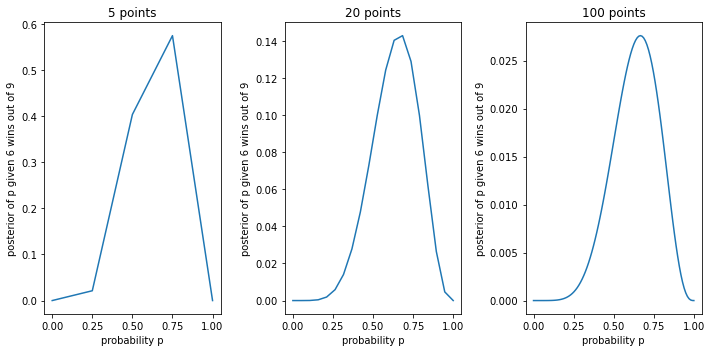

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(10,5))
for i, j in enumerate(grids):
    ax[i].plot(j[1], j[2])
    ax[i].set_xlabel('probability p')
    ax[i].set_ylabel('posterior of p given 6 wins out of 9')
    ax[i].set_title(f'{j[0]} points')
    
plt.tight_layout()

### Quadratic approximator, Code 2.6

In [45]:
def model(W, L):
    p = numpyro.sample("p", dist.Uniform(0, 1))  # uniform prior
    numpyro.sample("W", dist.Binomial(W + L, p), obs=W)  # binomial likelihood

# Laplace approximation (quadratic approximation) approximates
# the posterior by a multivariate normal distribution in the unconstrained space
guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim.Adam(1), Trace_ELBO(), W=12, L=6)
svi_result = svi.run(random.PRNGKey(0), 1000)
params = svi_result.params

# display summary of quadratic approximation
samples = guide.sample_posterior(random.PRNGKey(1), params, (1000,))
# prob gives the Highest Density Region (HDR) Interval == credible interval?
numpyro.diagnostics.print_summary(samples, prob=0.89, group_by_chain=False)


100%|█████████| 1000/1000 [00:00<00:00, 1451.00it/s, init loss: 3.4896, avg. loss [951-1000]: 3.1200]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         p      0.64      0.10      0.64      0.48      0.80    845.50      1.00



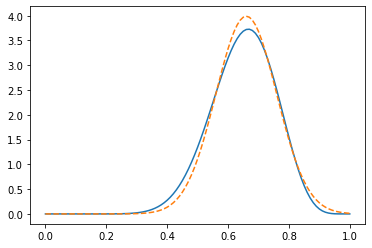

In [47]:
# compare to analytical calculation
W = 12
L = 6
x = jnp.linspace(0, 1, 101)
# the conjuction of a binomial likelihood with a uniform prior (special beta function)
# results in a beta posterior: https://stats.stackexchange.com/questions/185221/binomial-uniform-prior-bayesian-statistics
plt.plot(x, jnp.exp(dist.Beta(W + 1, L + 1).log_prob(x)))
# quadratic approximation
plt.plot(x, jnp.exp(dist.Normal(0.66, 0.10).log_prob(x)), "--")
plt.show()

### MCMC, Code 2.8

In [61]:
n_samples = 10000
p = [jnp.nan] * n_samples
p[0] = 0.5
W = 6
L = 3
with numpyro.handlers.seed(rng_seed=0):
    for i in range(1, n_samples):
        p_new = numpyro.sample("p_new", dist.Normal(p[i - 1], 0.1))
        p_new = jnp.abs(p_new) if p_new < 0 else p_new
        p_new = 2 - p_new if p_new > 1 else p_new
        # likelihood given sampled p
        q0 = jnp.exp(dist.Binomial(W + L, p[i - 1]).log_prob(W))
        q1 = jnp.exp(dist.Binomial(W + L, p_new).log_prob(W))
        u = numpyro.sample("u", dist.Uniform())
        p[i] = p_new if u < q1 / q0 else p[i - 1]


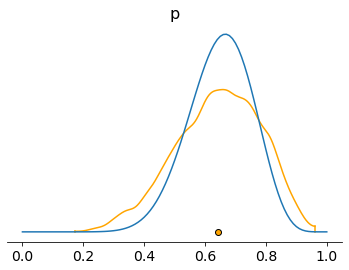

In [62]:
# compare to analytical calculation
W = 12
L = 6
x = jnp.linspace(0, 1, 101)
az.plot_density({"p": p}, hdi_prob=1, colors='orange')
plt.plot(x, jnp.exp(dist.Beta(W + 1, L + 1).log_prob(x)))
plt.show()


## Exercises

### 2M2

In [68]:
# for case 3: L, W, W, L, W, W, W
grids = []
for i in [5, 20, 100]:
    # define grid
    p_grid = np.linspace(0, 1, i)

    # define prior - half uniform
    prior = np.array([0 if p < 0.5 else 1 for p in p_grid])

    # compute likelihood at each value in grid
    # log_prob calculates the log probabilities of observed 5 wins out of 7 samples
    # for the different probabilities
    likelihood = jnp.exp(dist.Binomial(total_count=7, probs=p_grid).log_prob(5))

    # product of likelihood and prior 
    unstd_posterior = likelihood * prior

    # standardize by evidence, marginal likelihood
    posterior = unstd_posterior / jnp.sum(unstd_posterior)
    
    grids += [[i, p_grid, posterior]]

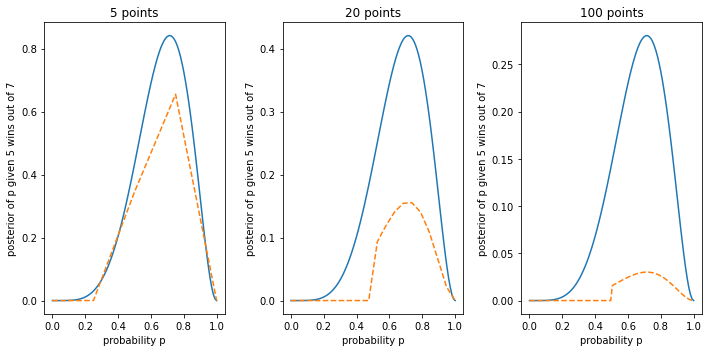

In [72]:
fig, ax = plt.subplots(1, 3, figsize=(10,5))
# compare to analytical calculation
W = 5
L = 2
x = jnp.linspace(0, 1, 101)
y = jnp.exp(dist.Beta(W + 1, L + 1).log_prob(x))
for i, j in enumerate(grids):
    ax[i].plot(x, y*0.33/(i+1))

    ax[i].plot(j[1], j[2], "--")
    ax[i].set_xlabel('probability p')
    ax[i].set_ylabel('posterior of p given 5 wins out of 7')
    ax[i].set_title(f'{j[0]} points')
    
plt.tight_layout()